# Exploracion de datos 

# Importacion de datos desde API
No requiere credenciales

In [51]:
from typing import Final
import requests
import zipfile
import io
import pandas as pd
import os
import logging
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

DATA_DIR: Final = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'raw'
)

file_path = os.path.join(DATA_DIR, 'online_retail_II.xlsx')

if not os.path.exists(file_path):
    url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
    response = requests.request("GET", url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall(path=DATA_DIR)
    logging.info("Downloaded and extracted the zip file")

# Load the .xlsx file into a pandas dataframe
year_2009_2010 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
year_2010_2011 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
logging.info("Loaded the data into a pandas dataframe")

df = pd.concat([year_2009_2010, year_2010_2011], ignore_index=True)
df.head(1)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom


Observamos los tipos de datos disponibles

In [52]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [53]:
df.shape

(1067371, 8)

In [54]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# Descripción de las variables

In [55]:
# estadísticas de las columnas categoricas
df.describe( include=['object', 'string'])

,Invoice,StockCode,Description,Country
count,1067371,1067371,1062989,1067371
unique,53628,5305,5698,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1350,5829,5918,981330


Podemos ver que en el campo Description tenemos valores nulos a analizar. El país con mayores ventas es United Kingdom, tenemos 40 países. El Invoice es el indicador de factura, en realidad en todo el dataset se realizaron 28816 ventas facturadas. 

In [56]:
df.describe( include=['float64', 'int64'])

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


En la variable Quantity hay valores fuera de serie grandes, los datos se concentran en valores cercanos a 10, por lo que existe un sesgo a la derecha, es decir los valores tienen una asímetría positiva. Por ende, los datos deben ser escalados o aplicados con un logaritmo en caso de aplicar modelos estadísticos con supuestos en distribuciones normales. El precio presenta el mismo problema de asimetría positiva. Para el Customer se debe cambiar de número a objeto ya que nos interesa la cantidad que veces que compró un mismo cliente, no operaciones entre el ID. 

In [57]:
df.describe( include= 'datetime64[ns]')

,InvoiceDate
count,1067371
mean,2011-01-02 21:13:55.394028544
min,2009-12-01 07:45:00
25%,2010-07-09 09:46:00
50%,2010-12-07 15:28:00
75%,2011-07-22 10:23:00
max,2011-12-09 12:50:00


En cuanto al tiempo, el rango o periodo es desde 2009 diciembre hasta 2011 diciembre, abarcando un dos años de ventas online. 

# Analisis de valores faltantes

Lo que realizaremos es un analisis de los valores faltantes para descartar cualquier valor nulo por error de digitación. Para ello, compararemos por StockCode para ver si en el periodo de estudio existe un misdo StockCode con el valor que podría ir en los valores faltantes. 

In [58]:
# Step 1: Filter rows where Description or CustomerID is missing
missing_values_df = df[df['Description'].isna() | df['Customer ID'].isna()]

# Step 2: Group by Stockcode or InvoiceID
grouped_by_stockcode = missing_values_df.groupby('StockCode')

# Stockcode example
inconsistent_stockcode = grouped_by_stockcode.apply(
    lambda x: x[['Description', 'Customer ID']].isna().all(axis=0)
).reset_index()

# Filtering the inconsistent groups where not all values are missing
inconsistent_stockcodes = inconsistent_stockcode[inconsistent_stockcode.any(axis=1)]

In [59]:
# no siempre son valores nulos estos codigos:
inconsistent_stockcodes.loc[inconsistent_stockcodes.Description == False]

,StockCode,Description,Customer ID
0,10002,False,True
1,10080,False,True
3,10120,False,True
4,10125,False,True
5,10133,False,True
...,...,...,...
5170,gift_0001_40,False,True
5171,gift_0001_50,False,True
5173,gift_0001_70,False,True
5174,gift_0001_80,False,True


Como ejemplo, veamos gift_0001_80 de codigo de Stock, este tiene dos valores posibles como vemos a continuación:

In [60]:
df.loc[df['StockCode'] == 'gift_0001_80'].Description.unique() 

array([nan, 'Dotcomgiftshop Gift Voucher £80.00'], dtype=object)

Como vimos, hay valores que tienen dos opciones o hasta 3. Por ahora vamos a cambiar los valores de nan por el valor que se utiliza en la serie:

In [61]:
# Step 1: Group by StockCode and get unique values in Description
unique_values = df.groupby('StockCode')['Description'].unique()

# Step 2: Identify StockCodes with exactly one non-null and one NaN value
stockcodes_to_impute = unique_values[unique_values.apply(lambda x: len(x) == 2 and pd.isna(x).any())]

# Step 3: Create a dictionary for imputation (mapping StockCode to its non-null Description)
imputation_dict = {stockcode: next(val for val in values if pd.notna(val)) 
                   for stockcode, values in stockcodes_to_impute.items()}


Acá vemos una lista de los códgios de Stock y su respectivo valor no nulo

In [62]:
imputation_dict

{10002: 'INFLATABLE POLITICAL GLOBE ',
 10109: 'BENDY COLOUR PENCILS',
 10134: 'COLOURING PENCILS BROWN TUBE',
 10138: 'ASSORTED COLOUR JUMBO PEN',
 15030: 'FAN BLACK FRAME ',
 15036: 'ASSORTED COLOURS SILK FAN',
 16010: 'FOLDING CAMPING SCISSOR W/KNIF & S',
 16015: 'MEDIUM CHINESE STYLE SCISSOR',
 16033: 'MINI HIGHLIGHTER PENS',
 16043: 'POP ART PUSH DOWN RUBBER ',
 16044: 'POP-ART FLUORESCENT PENS',
 16046: 'TEATIME PEN CASE & PENS',
 16047: 'POP ART PEN CASE & PENS',
 16049: 'TEATIME GEL PENS ASST',
 16050: 'TEATIME PENCIL WITH RUBBER',
 16051: 'TEATIME PENCIL W STAMP ASST',
 16052: 'TEATIME PUSH DOWN RUBBER',
 16053: 'POPART COL BALLPOINT PEN ASST',
 16119: 'FUNKY GIRL ADDRESS BOOK',
 16192: 'PINK BALLET OPENING CUBE BOX ',
 16212: 'FUNKY GIRLZ ASST MAGNETIC MEMO PAD',
 16215: 'FUNKY GIRLZ MAGNETIC TO DO LIST ',
 16239: 'BALLERINA HEART DECORATION.',
 16254: 'TRANSPARENT ACRYLIC TAPE DISPENSER',
 16259: 'PIECE OF CAMO STATIONERY SET',
 17001: 'HEAVENS SCENT FRAGRANCE OILS ASSTD',
 

Vamos a proceder a remplazar los valores nulos cuando al descripción es un valor nulo y su codigo está en el diccionario que creamos:

In [63]:
# Step 4: Apply the imputation only for the same StockCode
df['Description'] = df.apply(
    lambda row: imputation_dict[row['StockCode']] 
    if pd.isna(row['Description']) and row['StockCode'] in imputation_dict else row['Description'], axis=1
)

Veamos el mismo ejemplo de antes:

In [64]:
df.loc[df['StockCode'] == 'gift_0001_80'].Description.unique() 

array(['Dotcomgiftshop Gift Voucher £80.00'], dtype=object)

Procedemos a ver los valores nulos nuevamente:

In [65]:
df.isna().sum()

Invoice             0
StockCode           0
Description      1320
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

reducimos los valores nulos de Description de 4382 a 1320 una reducción del 70% aproximadamente con este enfoque.
Ahora veamos los valores faltantes y detectemos cuando estos valores son solamente nulos:

# Valores que siempre son nulos en el código de stock

In [66]:
# Step 1: Filter rows where Description or CustomerID is missing
missing_values_df = df[df['Description'].isna() | df['Customer ID'].isna()]

# Step 2: Group by Stockcode or InvoiceID
grouped_by_stockcode = missing_values_df.groupby('StockCode')

# Stockcode example
inconsistent_stockcode = grouped_by_stockcode.apply(
    lambda x: x[['Description', 'Customer ID']].isna().all(axis=0)
).reset_index()

# Filtering the inconsistent groups where not all values are missing
inconsistent_stockcodes = inconsistent_stockcode[inconsistent_stockcode.any(axis=1)]



In [67]:
# siempre son valores nulos estos codigos:
inconsistent_stockcodes.loc[inconsistent_stockcodes.Description == True]

,StockCode,Description,Customer ID
35,16131,True,True
36,16132,True,True
38,16195,True,True
39,16210,True,True
51,16240,True,True
...,...,...,...
5156,DCGSLBOY,True,True
5157,DCGSLGIRL,True,True
5161,GIFT,True,True
5172,gift_0001_60,True,True


In [68]:
df.loc[df['StockCode'] == 'gift_0001_60'].Description.unique() 

array([nan], dtype=object)

Como vemos, tenemos 361 casos en donde el valor de Descripcion siempre es nulo. Ahora para analizar como la eliminación de estos valores afectaría un modelo predictivo: 

In [69]:
# agrupamos por StockCode
grouped_by_stockcode = df.groupby('StockCode')
stockcodes_with_nan = grouped_by_stockcode.apply(lambda x: x['Description'].isna().all())
stockcodes_with_nan = stockcodes_with_nan[stockcodes_with_nan].index.tolist()

In [70]:
stockcodes_with_nan
# un vistazo de los StockCode que siempre son nulos en descripcion

[16131,
 16132,
 16195,
 16210,
 16240,
 16255,
 17017,
 17120,
 17160,
 18033,
 20690,
 20691,
 20710,
 20720,
 20743,
 20824,
 20844,
 20859,
 20880,
 20883,
 20900,
 20904,
 20911,
 20937,
 20938,
 20944,
 20946,
 20951,
 20955,
 20959,
 20965,
 20995,
 21005,
 21019,
 21020,
 21021,
 21022,
 21023,
 21024,
 21029,
 21047,
 21048,
 21052,
 21057,
 21083,
 21104,
 21113,
 21148,
 21170,
 21176,
 21177,
 21182,
 21183,
 21227,
 21236,
 21273,
 21295,
 21301,
 21325,
 21342,
 21345,
 21362,
 21487,
 21492,
 21502,
 21505,
 21510,
 21512,
 21514,
 21583,
 21601,
 21602,
 21646,
 21753,
 21776,
 21778,
 21835,
 21855,
 21859,
 21862,
 21863,
 21909,
 21920,
 22022,
 22213,
 35232,
 35442,
 35473,
 35763,
 35794,
 35839,
 35900,
 35925,
 35926,
 35935,
 35940,
 35941,
 35948,
 35949,
 35960,
 35983,
 35990,
 35992,
 35993,
 35994,
 37350,
 37353,
 37504,
 44276,
 47009,
 47361,
 47559,
 47565,
 48169,
 48172,
 71265,
 71431,
 72234,
 72483,
 72719,
 72748,
 72768,
 72777,
 72778,
 72806,


Podemos ver un resumen estadistico de los valores que siempre son nulos en StockCode:

In [71]:
df.loc[df['StockCode'].isin(stockcodes_with_nan)].describe(include=['int64', 'float64'])

,Quantity,Price,Customer ID
count,363.000000,363.0,0.0
mean,-44.201102,0.0,NaN
std,327.616760,0.0,NaN
min,-4999.000000,0.0,NaN
25%,-23.000000,0.0,NaN
50%,-7.000000,0.0,NaN
75%,-1.000000,0.0,NaN
max,160.000000,0.0,NaN


Con esto vemos que también son siempre nulos los valores de Customer ID, el precio es 0 siempre y las cantidades son negativas o con un maximo de 160 cantidades, concentrandoce en -44 los datos, pero tenemos una asímetría positiva en los datos, es decir hay valores muy negativos que afectan el calculo llegando hasta -5000 aproximadamente. 


Por lo anterior, podemos eliminar los valores nulos, abajo dejo una grafica donde muestro que con esto se afecta únicamente los valores de reino unido. 

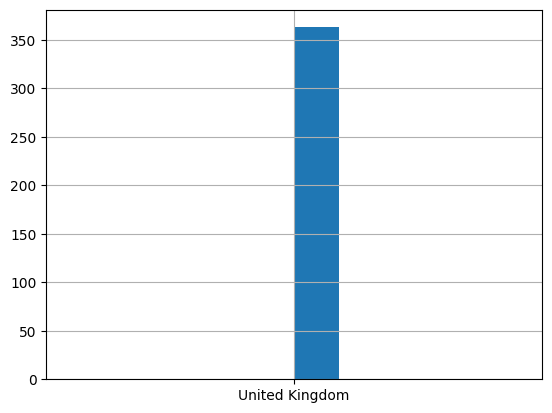

In [72]:
df.loc[df['StockCode'].isin(stockcodes_with_nan)]['Country'].hist()
plt.show()

procedemos a eliminar los valores nulos del dataframe y lo renombramos

In [73]:
df = df[~df['StockCode'].isin(stockcodes_with_nan)]

In [74]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067008e+06,1067008,1.067008e+06,824364.000000
mean,9.957317e+00,2011-01-02 23:50:41.346493696,4.650969e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 11:44:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:52:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.726268e+02,NaN,1.235740e+02,1697.464450


# remplazo de valores nulos en descripción segun multiples opciones en Stock Code

Vamos a remplazar los demás valores para facilitar los calculos en los demás casos:

In [102]:
# Step 1: Group by StockCode and get unique values in Description
unique_values = df.groupby('StockCode')['Description'].unique()

# Step 2: Identify StockCodes with exactly one non-null and one NaN value
stockcodes_to_impute = unique_values[unique_values.apply(lambda x: len(x) >= 2)]

# Step 3: Create a dictionary for imputation (mapping StockCode to its non-null Description)
imputation_dict = {stockcode: values.tolist() for stockcode, values in stockcodes_to_impute.items() if pd.notna(stockcode)}


Vemos abajo que los valores que remplazan a nan pueden ser una palabra con letras capitales o minuscula

In [103]:
imputation_dict

{10080: ['GROOVY CACTUS INFLATABLE', nan, 'check'],
 10120: ['DOGGY RUBBER', 'Zebra invcing error'],
 10133: ['COLOURING PENCILS BROWN TUBE', 'damaged'],
 16008: ['SMALL FOLDING SCISSOR(POINTED EDGE)', 'check'],
 16011: [' ANIMAL STICKERS', 'ANIMAL STICKERS'],
 16012: ['FOOD/DRINK SPUNGE STICKERS', 'FOOD/DRINK SPONGE STICKERS'],
 16045: ['POPART WOODEN PENCILS ASST', nan, 'check'],
 16235: ['RECYCLED PENCIL WITH RABBIT ERASER', '?'],
 17033: ['BROCADE PURSE,SMALL ARCH BUTTON',
  'sold as 17003?',
  'Sold as 17003?',
  nan],
 20615: ['BLUE SPOTTY PASSPORT COVER', 'BLUE POLKADOT PASSPORT COVER'],
 20622: ['VIPPASSPORT COVER ', 'VIP PASSPORT COVER '],
 20652: ['BLUE SPOTTY LUGGAGE TAG ',
  nan,
  'BLUE POLKADOT LUGGAGE TAG ',
  'check'],
 20658: ['RED SPOTTY LUGGAGE TAG', 'RED RETROSPOT LUGGAGE TAG', nan],
 20661: ['BLUE SPOTTY PURSE ', 'BLUE POLKADOT PURSE '],
 20665: ['RED SPOTTY PURSE ',
  'RED RETROSPOT PURSE ',
  nan,
  'dotcom',
  'adjustment'],
 20674: ['GREEN SPOTTY BOWL', 'GREEN 

Un ejemplo de los casos que tienen más de un caso para remplazar: 

In [104]:
df.loc[df['StockCode'] == 10080].Description.unique()

array(['GROOVY CACTUS INFLATABLE', nan, 'check'], dtype=object)

generamos una función para encontrar los valores que son letra pequeña como  'check'

In [105]:
def find_unique_lowercase_values(d):
    unique_values = set()
    for lst in d.values():
        for item in lst:
            if isinstance(item, str) and item.islower():
                unique_values.add(item)
    return list(unique_values)

In [106]:
lowercase_dict = find_unique_lowercase_values(imputation_dict)
len(lowercase_dict)
lowercase_dict


['incorrectly put back into stock',
 'wedding co returns?',
 '?missing',
 'show display',
 'sold as set on dotcom',
 'found some more on shelf',
 'found again',
 'dotcom email',
 'damaged/dirty',
 'wet cartons',
 'historic computer difference?....se',
 'damages?',
 'wrong barcode',
 'wet & rotting',
 'damaged?',
 'wet pallet',
 'test',
 'mailout ',
 'cracked',
 'mixed up',
 'wet/smashed/unsellable',
 'rusty throw away',
 'water damage',
 'display stands',
 'tk maxx mix up with pink',
 'sold in wrong qnty',
 'debenhams',
 'stock check',
 '17129c',
 'wet',
 'wrongly marked',
 'entry error',
 'wrongly sold sets',
 'code mix up 72597',
 'rcvd be air temp fix for dotcom sit',
 'correct previous adjustment',
 'stock take',
 'missing?',
 'wet?',
 'barcode problem',
 "can't find",
 'mouldy, unsaleable.',
 'rusty thrown away',
 'temp adjustment',
 'incorrect stock entry.',
 'damages',
 'reverse 21/5/10 adjustment',
 'for online retail orders',
 'incorrectly made-thrown away.',
 'mailout',
 'gon

de estos valores de letra pequeña, existen codigos que eran los que realmente iban a marcas

In [107]:
import re
numeric_values = [value for value in lowercase_dict if re.findall(r'\D*(\d+)\D*', value)]
numeric_values

['17129c',
 'code mix up 72597',
 'reverse 21/5/10 adjustment',
 'invoice 506647',
 'sold as 22467',
 '85123a mixed',
 'wrongly coded-23343',
 'wrongly coded 20713',
 'sold as 1',
 'invcd as 84879?',
 'sold as set/6 on dotcom',
 'wrongly marked carton 22804',
 'wrongly marked. 23343 in box',
 'wrongly marked 23343',
 '20713 wrongly marked',
 'wrong barcode (22467)',
 'sold as 17003?',
 'wrongly sold (22719) barcode',
 'wrongly coded 23343',
 '21733 mixed',
 'came coded as 20713',
 'code mix up? 84930',
 'sold as set/6 by dotcom']

Estos son los posibles errores en operación solucionables desde la data, por ende podemos remplazar el stock code con valoes que si eran. Esto debido a que el sistema no deja cambiar, probablemente por la facturación 

In [108]:
# TODO: Impute the missing values for the StockCode
result_dict = {}
# Loop through each item in the list
for text in numeric_values:
    # Find all numbers in the text
    numbers = re.findall(r'\D*(\d+)\D*', text)
    if len(str(numbers)) > 0:
        # Use the first number as the key (assuming only one number per string)
        key = int(numbers[0])
        # Store the entire text as the value
        result_dict[text] = key

result_dict

{'17129c': 17129,
 'code mix up 72597': 72597,
 'reverse 21/5/10 adjustment': 21,
 'invoice 506647': 506647,
 'sold as 22467': 22467,
 '85123a mixed': 85123,
 'wrongly coded-23343': 23343,
 'wrongly coded 20713': 20713,
 'sold as 1': 1,
 'invcd as 84879?': 84879,
 'sold as set/6 on dotcom': 6,
 'wrongly marked carton 22804': 22804,
 'wrongly marked. 23343 in box': 23343,
 'wrongly marked 23343': 23343,
 '20713 wrongly marked': 20713,
 'wrong barcode (22467)': 22467,
 'sold as 17003?': 17003,
 'wrongly sold (22719) barcode': 22719,
 'wrongly coded 23343': 23343,
 '21733 mixed': 21733,
 'came coded as 20713': 20713,
 'code mix up? 84930': 84930,
 'sold as set/6 by dotcom': 6}

comparamos antes:

In [110]:
df_test = df.copy()

In [113]:
df.loc[df['Description'].str.contains('wrongly marked.', na=False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
789345,560039,20713,wrongly marked. 23343 in box,-3100,2011-07-14 14:27:00,0.0,NaN,United Kingdom
941043,572547,20713,wrongly marked 23343,200,2011-10-24 17:01:00,0.0,NaN,United Kingdom
982292,575722,85123A,wrongly marked carton 22804,-256,2011-11-10 18:20:00,0.0,NaN,United Kingdom


In [111]:

df_test['StockCode'] = df_test.apply(
    lambda row: result_dict[row['Description']] 
    if row['Description'] in result_dict else row['StockCode'], axis=1
)

comparamos despues:

In [112]:
df_test.loc[df_test['Description'].str.contains('wrongly marked.', na=False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
789345,560039,23343,wrongly marked. 23343 in box,-3100,2011-07-14 14:27:00,0.0,NaN,United Kingdom
941043,572547,23343,wrongly marked 23343,200,2011-10-24 17:01:00,0.0,NaN,United Kingdom
982292,575722,22804,wrongly marked carton 22804,-256,2011-11-10 18:20:00,0.0,NaN,United Kingdom


# cambio de palabras en minúscula por el item correcto en Descripción

Otra función para detectar las palabras de descripción con valores en mayúscula

In [114]:
def find_uppercase_in_dict(d):
    result = {}
    for key, lst in d.items():
        lowercase_elements = [item for item in lst if isinstance(item, str) and item.isupper()]
        if lowercase_elements:
            result[key] = lowercase_elements
    return result

# Get dictionary with only lowercase elements
upper_case = find_uppercase_in_dict(imputation_dict)
upper_case

{10080: ['GROOVY CACTUS INFLATABLE'],
 10120: ['DOGGY RUBBER'],
 10133: ['COLOURING PENCILS BROWN TUBE'],
 16008: ['SMALL FOLDING SCISSOR(POINTED EDGE)'],
 16011: [' ANIMAL STICKERS', 'ANIMAL STICKERS'],
 16012: ['FOOD/DRINK SPUNGE STICKERS', 'FOOD/DRINK SPONGE STICKERS'],
 16045: ['POPART WOODEN PENCILS ASST'],
 16235: ['RECYCLED PENCIL WITH RABBIT ERASER'],
 17033: ['BROCADE PURSE,SMALL ARCH BUTTON'],
 20615: ['BLUE SPOTTY PASSPORT COVER', 'BLUE POLKADOT PASSPORT COVER'],
 20622: ['VIPPASSPORT COVER ', 'VIP PASSPORT COVER '],
 20652: ['BLUE SPOTTY LUGGAGE TAG ', 'BLUE POLKADOT LUGGAGE TAG '],
 20658: ['RED SPOTTY LUGGAGE TAG', 'RED RETROSPOT LUGGAGE TAG'],
 20661: ['BLUE SPOTTY PURSE ', 'BLUE POLKADOT PURSE '],
 20665: ['RED SPOTTY PURSE ', 'RED RETROSPOT PURSE '],
 20674: ['GREEN SPOTTY BOWL', 'GREEN POLKADOT BOWL'],
 20675: ['BLUE SPOTTY BOWL', 'BLUE POLKADOT BOWL'],
 20676: ['RED SPOTTY BOWL', 'RED RETROSPOT BOWL'],
 20677: ['PINK SPOTTY BOWL', 'PINK POLKADOT BOWL'],
 20679: ['EDW

In [115]:
df.loc[df['StockCode'] == 10080].groupby('Description').agg({'InvoiceDate': max}).sort_values(by='InvoiceDate', ascending=False)

,InvoiceDate
Description,
GROOVY CACTUS INFLATABLE,2011-11-21 17:04:00
check,2011-11-10 10:53:00


Para este ejercicio vamos a quedarnos solo con los valores que tienen una sola posibilidad en letra mayúscula

In [116]:
upper_case_single = {key: value[0] for key, value in upper_case.items() if len(value) == 1}
upper_case_single

{10080: 'GROOVY CACTUS INFLATABLE',
 10120: 'DOGGY RUBBER',
 10133: 'COLOURING PENCILS BROWN TUBE',
 16008: 'SMALL FOLDING SCISSOR(POINTED EDGE)',
 16045: 'POPART WOODEN PENCILS ASST',
 16235: 'RECYCLED PENCIL WITH RABBIT ERASER',
 17033: 'BROCADE PURSE,SMALL ARCH BUTTON',
 20679: 'EDWARDIAN PARASOL RED',
 20692: 'FLORAL ELEPHANT SOFT TOY',
 20694: 'FLORAL PINK MONSTER',
 20700: 'GREEN CAT FLORAL CUSHION COVER ',
 20711: 'JUMBO BAG TOYS ',
 20712: 'JUMBO BAG WOODLAND ANIMALS',
 20713: 'JUMBO BAG OWLS',
 20714: 'POSY SHOPPER BAG',
 20738: 'GREEN MINI TAPE MEASURE ',
 20748: 'KENSINGTON COFFEE SET',
 20751: 'FUNKY WASHING UP GLOVES ASSORTED',
 20774: 'GREEN FERN NOTEBOOK',
 20786: 'BLACK RETRO BAR STOOL',
 20787: 'BLUE RETRO BAR STOOL',
 20798: 'CLEAR MILKSHAKE GLASS',
 20799: 'PINK MILKSHAKE GLASS',
 20803: 'SMALL PINK GLASS SUNDAE DISH',
 20820: 'SILVER LOOKING MIRROR',
 20821: 'GOLDIE LOOKING MIRROR',
 20825: 'GOLD WINE GLASS',
 20827: 'GOLD APERITIF GLASS',
 20830: 'SILVER PHOTO FRAM

In [117]:
# Step 4: Apply the imputation only for the same StockCode

df['Description'] = df['Description'].astype(str) 
df['Description'] = df.apply(
    lambda row: upper_case_single[row['StockCode']] 
    if row['StockCode'] in upper_case_single else row['Description'], axis=1
)

In [118]:
df.loc[df['StockCode'] == 10080].groupby('Description').agg({'InvoiceDate': max}).sort_values(by='InvoiceDate', ascending=False)

,InvoiceDate
Description,
GROOVY CACTUS INFLATABLE,2011-11-21 17:04:00


In [119]:
df.isna().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    242644
Country             0
dtype: int64

Con esto explicamos el 100% de los valores nulos en Description. En los casos donde se tiene una variable en mayúscula y otra en minuscula, se quedó con la variable en mayúscula. Hay casos donde hay más de una descripción para la variable, estos no nos interesa por el momento

# analisis de valores nulos en customer ID 

In [ ]:
# analisis de valores nulos en customer ID
df_customer_id = df.loc[df['Customer ID'].isna()]
df_customer_id.Description.count()

In [121]:
df_customer_id.describe(include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,242644.0,242644,242644,242644.000000,242644,242644.000000,0.0,242644
unique,8389.0,4822,5085,NaN,NaN,NaN,NaN,15
top,537434.0,DOT,DOTCOM POSTAGE,NaN,NaN,NaN,NaN,United Kingdom
freq,1350.0,1430,1430,NaN,NaN,NaN,NaN,239666
mean,NaN,NaN,NaN,1.608979,2011-01-06 13:58:55.255023872,7.960635,NaN,NaN
min,NaN,NaN,NaN,-9600.000000,2009-12-01 10:52:00,-53594.360000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2010-07-23 15:09:00,1.660000,NaN,NaN
50%,NaN,NaN,NaN,1.000000,2010-12-20 16:08:00,3.290000,NaN,NaN
75%,NaN,NaN,NaN,2.000000,2011-07-12 16:11:00,5.790000,NaN,NaN
max,NaN,NaN,NaN,10200.000000,2011-12-09 10:26:00,25111.090000,NaN,NaN


0.22740598008637236

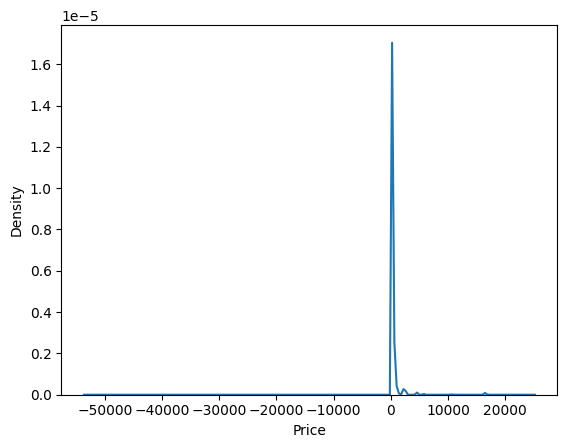

In [120]:

df_customer_id['Description'].value_counts()
df_customer_id.Price.describe()
import seaborn as sns
sns.kdeplot(df_customer_id.Price)
df_customer_id.shape[0] / df.shape[0]
# quitar los valores nulos en Customer ID es dejarnos con menos del 22% de la data

In [ ]:
# TODO: concluir en que hacer con los valores nulos en Customer ID